In [1]:
# Import könyvtárak
import os
import json
from pathlib import Path
import random
import shutil

import numpy as np
import math
import pandas as pd
import torch
import torch.nn as nn
from torch import amp
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys
import re

In [2]:
def set_seed(seed=42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
class LegalTextDataset(Dataset):
    """Dataset for legal text classification."""

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [4]:
def normalize_label(raw):
    s = str(raw).strip()
    m = re.match(r'^([1-5])', s)
    return int(m.group(1)) if m else 0


def build_ordinal_mapping(labels):
    numeric = [normalize_label(l) for l in labels]
    unique = sorted(set(numeric))
    label2id = {u: i for i, u in enumerate(unique)}
    id2label = {label2id[u]: str(u) for u in unique}
    encoded = [label2id[n] for n in numeric]
    return encoded, label2id, id2label

## Progressive Model Architectures

4 különböző modell architektúra definiálása:

In [5]:
class Step1_BaselineModel(nn.Module):
    """Step 1: Minimal baseline - Transformer + single linear classifier."""
    def __init__(self, transformer_model, num_classes=5):
        super().__init__()
        self.transformer = transformer_model
        self.num_classes = num_classes
        hidden_size = transformer_model.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=False,
            return_dict=True
        )
        pooled = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(pooled)
        
        output = type('Output', (), {'logits': logits})()
        if labels is not None:
            output.loss = nn.CrossEntropyLoss()(logits, labels)
        return output

In [6]:
class Step2_ExtendedModel(nn.Module):
    """Step 2: Extended - 2-layer adapter + BatchNorm + Dropout."""
    def __init__(self, transformer_model, num_classes=5, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.transformer = transformer_model
        self.num_classes = num_classes
        trans_hidden = transformer_model.config.hidden_size
        
        self.adapter = nn.Sequential(
            nn.Linear(trans_hidden, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.classifier = nn.Linear(hidden_dim // 2, num_classes)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=False,
            return_dict=True
        )
        pooled = outputs.last_hidden_state[:, 0, :]
        adapted = self.adapter(pooled)
        logits = self.classifier(adapted)
        
        output = type('Output', (), {'logits': logits})()
        if labels is not None:
            output.loss = nn.CrossEntropyLoss()(logits, labels)
        return output

In [7]:
class Step3_AdvancedModel(nn.Module):
    """Step 3: Advanced - Attention pooling + 3-layer adapter + gating."""
    def __init__(self, transformer_model, num_classes=5, hidden_dim=256, dropout=0.4, num_heads=4):
        super().__init__()
        self.transformer = transformer_model
        self.num_classes = num_classes
        trans_hidden = transformer_model.config.hidden_size
        
        # Attention pooling
        self.attention_pool = nn.MultiheadAttention(
            embed_dim=trans_hidden,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.query = nn.Parameter(torch.randn(1, 1, trans_hidden))
        
        # 3-layer adapter
        self.adapter_1 = nn.Sequential(
            nn.Linear(trans_hidden, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.adapter_2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.adapter_3 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.gate = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim // 2, num_classes)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=False,
            return_dict=True
        )
        hidden = outputs.last_hidden_state
        
        # Attention pooling
        batch_size = hidden.size(0)
        query = self.query.expand(batch_size, -1, -1)
        pooled, _ = self.attention_pool(query, hidden, hidden, key_padding_mask=~attention_mask.bool())
        pooled = pooled.squeeze(1)
        
        # 3-layer adapter with gating
        x = self.adapter_1(pooled)
        residual = x
        x = self.adapter_2(x)
        gate = torch.sigmoid(self.gate(x))
        x = gate * x + (1 - gate) * residual
        x = self.adapter_3(x)
        
        logits = self.classifier(x)
        
        output = type('Output', (), {'logits': logits})()
        if labels is not None:
            output.loss = nn.CrossEntropyLoss()(logits, labels)
        return output

In [8]:
class BalancedFinalModel(nn.Module):
    """Final: Balanced - Production-ready model with best practices."""
    def __init__(self, transformer_model, num_classes=5, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.transformer = transformer_model
        self.num_classes = num_classes
        trans_hidden = transformer_model.config.hidden_size
        
        self.adapter = nn.Sequential(
            nn.Linear(trans_hidden, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.classifier = nn.Linear(hidden_dim // 2, num_classes)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=False,
            return_dict=True
        )
        hidden = outputs.last_hidden_state
        
        # Mean pooling
        mask = attention_mask.unsqueeze(-1)
        summed = (hidden * mask).sum(1)
        counts = mask.sum(1).clamp(min=1)
        pooled = summed / counts
        
        adapted = self.adapter(pooled)
        logits = self.classifier(adapted)
        
        output = type('Output', (), {'logits': logits})()
        if labels is not None:
            output.loss = nn.CrossEntropyLoss()(logits, labels)
        return output

## Training Functions

In [9]:
def train_epoch(model, dataloader, optimizer, scheduler, device, criterion=None, grad_acc_steps=1):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    disable_tqdm = not sys.stdout.isatty()
    progress_bar = tqdm(dataloader, desc="Training", disable=disable_tqdm)
    scaler = amp.GradScaler('cuda', enabled=device.type == 'cuda')
    step_count = 0
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['label'].to(device, non_blocking=True)
        
        with amp.autocast('cuda', enabled=scaler.is_enabled()):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            if criterion is None:
                outputs_with_labels = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs_with_labels.loss / grad_acc_steps
            else:
                loss = criterion(logits, labels) / grad_acc_steps
        
        scaler.scale(loss).backward()
        step_count += 1
        
        if step_count % grad_acc_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
        
        total_loss += loss.item() * grad_acc_steps
        preds = torch.argmax(logits.detach(), dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        progress_bar.set_postfix({'loss': (total_loss / step_count)})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy

In [10]:
def evaluate(model, dataloader, device, criterion=None):
    """Evaluate model on validation/test set."""
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        disable_tqdm = not sys.stdout.isatty()
        progress_bar = tqdm(dataloader, desc="Evaluating", disable=disable_tqdm)
        mixed = device.type == 'cuda'
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['label'].to(device, non_blocking=True)
            
            with amp.autocast('cuda', enabled=mixed):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                
                if criterion is None:
                    outputs_with_labels = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs_with_labels.loss
                else:
                    loss = criterion(logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(logits.detach(), dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy, predictions, true_labels

In [11]:
def plot_training_history(history, save_path):
    """Plot training and validation metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    if 'val_loss' in history:
        ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy')
    if 'val_acc' in history:
        ax2.plot(epochs, history['val_acc'], 'r-', label='Val Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    fig.tight_layout()
    fig.savefig(save_path)
    plt.show()
    plt.close(fig)

In [12]:
def plot_model_comparison(all_results, save_path):
    """Plot comparison of all 4 models' performance."""
    model_names = list(all_results.keys())
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Val Accuracy Comparison
    val_accs = [all_results[name]['val_acc'] for name in model_names]
    train_accs = [all_results[name]['train_acc'] for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    axes[0, 0].bar(x - width/2, train_accs, width, label='Train Acc', color='#3498db')
    axes[0, 0].bar(x + width/2, val_accs, width, label='Val Acc', color='#e74c3c')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Train vs Val Accuracy Comparison')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(model_names, rotation=15, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Overfitting Gap
    gaps = [all_results[name]['train_acc'] - all_results[name]['val_acc'] for name in model_names]
    colors = ['#2ecc71' if g < 0.05 else '#f39c12' if g < 0.10 else '#e74c3c' for g in gaps]
    axes[0, 1].bar(model_names, gaps, color=colors)
    axes[0, 1].axhline(y=0.05, color='orange', linestyle='--', label='5% threshold')
    axes[0, 1].axhline(y=0.10, color='red', linestyle='--', label='10% threshold')
    axes[0, 1].set_ylabel('Train - Val Accuracy Gap')
    axes[0, 1].set_title('Overfitting Analysis')
    axes[0, 1].set_xticks(range(len(model_names)))
    axes[0, 1].set_xticklabels(model_names, rotation=15, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Convergence Speed
    epochs_to_best = [all_results[name]['epochs_trained'] for name in model_names]
    axes[1, 0].bar(model_names, epochs_to_best, color='#9b59b6')
    axes[1, 0].set_ylabel('Epochs')
    axes[1, 0].set_title('Training Epochs')
    axes[1, 0].set_xticks(range(len(model_names)))
    axes[1, 0].set_xticklabels(model_names, rotation=15, ha='right')
    axes[1, 0].grid(True, alpha=0.3)
    
    # F1 Scores
    macro_f1s = [all_results[name]['val_macro_f1'] for name in model_names]
    weighted_f1s = [all_results[name]['val_weighted_f1'] for name in model_names]
    
    axes[1, 1].bar(x - width/2, macro_f1s, width, label='Macro F1', color='#1abc9c')
    axes[1, 1].bar(x + width/2, weighted_f1s, width, label='Weighted F1', color='#34495e')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].set_title('F1 Score Comparison')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(model_names, rotation=15, ha='right')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    fig.tight_layout()
    fig.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print(f"Model comparison plot saved to {save_path}")

## Main Training Pipeline

Betöltjük az adatokat és tanítjuk mind a 4 modellt:

In [13]:
# Configuration
base_output = os.getenv('OUTPUT_DIR', '../output')
processed_dir = os.path.join(base_output, 'processed')
models_dir = os.path.join(base_output, 'models')
reports_dir = os.path.join(base_output, 'reports')

Path(models_dir).mkdir(parents=True, exist_ok=True)
Path(reports_dir).mkdir(parents=True, exist_ok=True)

# Hyperparameters
model_name = os.getenv('TRANSFORMER_MODEL', 'SZTAKI-HLT/hubert-base-cc')
batch_size = 8
epochs = 15
learning_rate = 1.5e-5
weight_decay = 0.01
max_length = 320
label_smoothing = 0.02
early_stopping_patience = 3
grad_acc_steps = 2

print(f"Base Model: {model_name}")
print(f"Batch Size: {batch_size} | Epochs: {epochs} | LR: {learning_rate}")

Base Model: SZTAKI-HLT/hubert-base-cc
Batch Size: 8 | Epochs: 15 | LR: 1.5e-05


In [14]:
# Load data
train_path = os.path.join(processed_dir, "train.csv")
val_path = os.path.join(processed_dir, "val.csv")

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path) if os.path.exists(val_path) else None

print(f"Train samples: {len(train_df)}")
if val_df is not None:
    print(f"Val samples: {len(val_df)}")

display(train_df.head())

Train samples: 2100
Val samples: 701


,text,label,word_count,avg_word_len
0,a regisztráció eredményeként a rossmann létreh...,4-Érthető,58,7.120690
1,"arról, hogy az adott településen vagy települé...",4-Érthető,111,6.909910
2,"3/12. vatera fenntartja a jogot, hogy bizonyos...",4-Érthető,45,7.044444
3,a vállalkozó a szerződés teljesítése során tud...,1-Nagyon nehezen érthető,92,7.315217
4,3/5. a felhasználónak a vaterán tett ajánlatai...,4-Érthető,10,8.000000


In [15]:
# Prepare labels
y_train_str = train_df['label'].astype(str).tolist()
y_train, label2id, id2label = build_ordinal_mapping(y_train_str)

# Save label mapping
label_map_path = os.path.join(models_dir, 'label_mapping.json')
with open(label_map_path, 'w', encoding='utf-8') as f:
    json.dump({'label2id': label2id, 'id2label': id2label}, f, ensure_ascii=False, indent=2)

num_labels = len(label2id)
print(f"Number of labels: {num_labels}")
print(f"Label mapping: {label2id}")

Number of labels: 5
Label mapping: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}


In [16]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    total_mem = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"GPU: {gpu_name} | Total VRAM: {total_mem:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 2050 | Total VRAM: 4.00 GB


In [17]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Prepare datasets
X_train = train_df['text'].astype(str).tolist()
train_dataset = LegalTextDataset(X_train, y_train, tokenizer, max_length)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=device.type=='cuda',
    num_workers=0
)

val_loader = None
if val_df is not None:
    y_val_str = val_df['label'].astype(str).tolist()
    y_val_numeric = [normalize_label(label) for label in y_val_str]
    y_val = [label2id[n] for n in y_val_numeric]
    X_val = val_df['text'].astype(str).tolist()
    val_dataset = LegalTextDataset(X_val, y_val, tokenizer, max_length)
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=device.type=='cuda',
        num_workers=0
    )

In [18]:
# Compute class weights
class_weights_raw = compute_class_weight('balanced', classes=np.unique(y_train), y=np.array(y_train))
class_weights = np.sqrt(class_weights_raw)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights (sqrt-scaled): {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=label_smoothing)

Class weights (sqrt-scaled): [2.01932412 1.30399573 0.96182646 0.80383695 0.80632177]


## Train All 4 Models

Most tanítjuk mind a 4 modell architektúrát és összehasonlítjuk őket:

In [19]:
# Model configs
model_configs = [
    {
        'name': 'Step1_Baseline',
        'class': Step1_BaselineModel,
        'description': 'Minimal baseline: Transformer + single linear classifier'
    },
    {
        'name': 'Step2_Extended',
        'class': Step2_ExtendedModel,
        'description': '2-layer adapter + BatchNorm + Dropout(0.3)'
    },
    {
        'name': 'Step3_Advanced',
        'class': Step3_AdvancedModel,
        'description': 'Attention pooling + 3-layer adapter + gating mechanism'
    },
    {
        'name': 'Final_Balanced',
        'class': BalancedFinalModel,
        'description': 'PRODUCTION RECOMMENDED: Mean pooling + balanced architecture'
    }
]

all_results = {}


Training Step1_Baseline
Architecture: Minimal baseline: Transformer + single linear classifier


Epoch 1/15
Train Loss: 1.6245, Train Accuracy: 0.2486
Val Loss: 1.5453, Val Acc: 0.3566, Val Weighted-F1: 0.2930
✓ New best (val_weighted_f1 = 0.2930)

Epoch 2/15
Train Loss: 1.4580, Train Accuracy: 0.4019
Val Loss: 1.4232, Val Acc: 0.3738, Val Weighted-F1: 0.3208
✓ New best (val_weighted_f1 = 0.3208)

Epoch 3/15
Train Loss: 1.3419, Train Accuracy: 0.4333
Val Loss: 1.4028, Val Acc: 0.4422, Val Weighted-F1: 0.3945
✓ New best (val_weighted_f1 = 0.3945)

Epoch 4/15
Train Loss: 1.2751, Train Accuracy: 0.4757
Val Loss: 1.3915, Val Acc: 0.4365, Val Weighted-F1: 0.3917

Epoch 5/15
Train Loss: 1.2176, Train Accuracy: 0.5076
Val Loss: 1.3624, Val Acc: 0.4308, Val Weighted-F1: 0.4221
✓ New best (val_weighted_f1 = 0.4221)

Epoch 6/15
Train Loss: 1.1226, Train Accuracy: 0.5686
Val Loss: 1.3886, Val Acc: 0.4508, Val Weighted-F1: 0.4385
✓ New best (val_weighted_f1 = 0.4385)

Epoch 7/15
Train Loss: 1.099

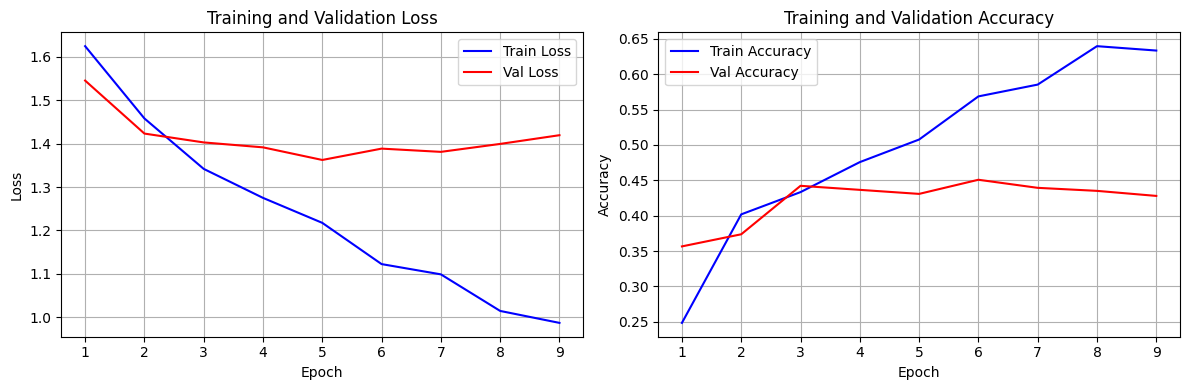


Training Step2_Extended
Architecture: 2-layer adapter + BatchNorm + Dropout(0.3)


Epoch 1/15
Train Loss: 1.6987, Train Accuracy: 0.1814
Val Loss: 1.6172, Val Acc: 0.2225, Val Weighted-F1: 0.2374
✓ New best (val_weighted_f1 = 0.2374)

Epoch 2/15
Train Loss: 1.6370, Train Accuracy: 0.2448
Val Loss: 1.5517, Val Acc: 0.3267, Val Weighted-F1: 0.3230
✓ New best (val_weighted_f1 = 0.3230)

Epoch 3/15
Train Loss: 1.5940, Train Accuracy: 0.2871
Val Loss: 1.5043, Val Acc: 0.3367, Val Weighted-F1: 0.3240
✓ New best (val_weighted_f1 = 0.3240)

Epoch 4/15
Train Loss: 1.5387, Train Accuracy: 0.3267
Val Loss: 1.4561, Val Acc: 0.3695, Val Weighted-F1: 0.3388
✓ New best (val_weighted_f1 = 0.3388)

Epoch 5/15
Train Loss: 1.4988, Train Accuracy: 0.3643
Val Loss: 1.4416, Val Acc: 0.3994, Val Weighted-F1: 0.3851
✓ New best (val_weighted_f1 = 0.3851)

Epoch 6/15
Train Loss: 1.4608, Train Accuracy: 0.3933
Val Loss: 1.4226, Val Acc: 0.3923, Val Weighted-F1: 0.3617

Epoch 7/15
Train Loss: 1.4490, Train Accur

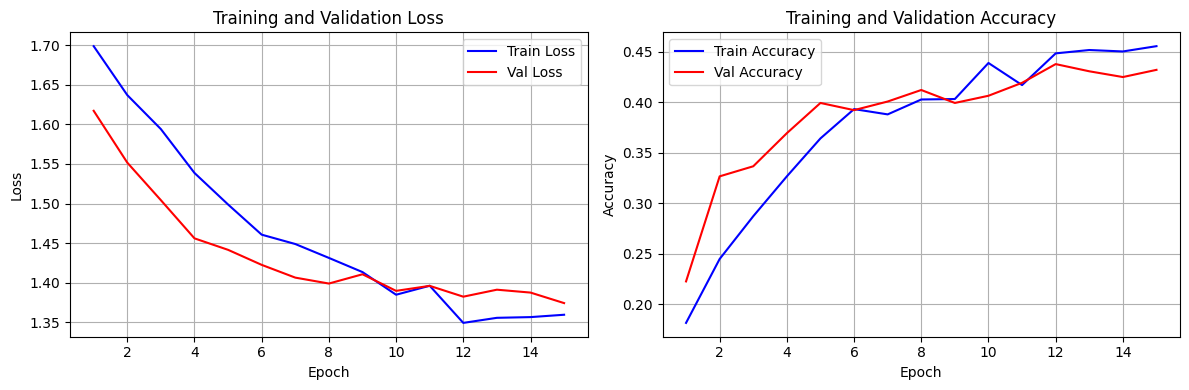


Training Step3_Advanced
Architecture: Attention pooling + 3-layer adapter + gating mechanism


Epoch 1/15
Train Loss: 1.7038, Train Accuracy: 0.1967
Val Loss: 1.5459, Val Acc: 0.3338, Val Weighted-F1: 0.2645
✓ New best (val_weighted_f1 = 0.2645)

Epoch 2/15
Train Loss: 1.6050, Train Accuracy: 0.2776
Val Loss: 1.5036, Val Acc: 0.3951, Val Weighted-F1: 0.3214
✓ New best (val_weighted_f1 = 0.3214)

Epoch 3/15
Train Loss: 1.5462, Train Accuracy: 0.3300
Val Loss: 1.4127, Val Acc: 0.4294, Val Weighted-F1: 0.3768
✓ New best (val_weighted_f1 = 0.3768)

Epoch 4/15
Train Loss: 1.4538, Train Accuracy: 0.3929
Val Loss: 1.3874, Val Acc: 0.4180, Val Weighted-F1: 0.3815
✓ New best (val_weighted_f1 = 0.3815)

Epoch 5/15
Train Loss: 1.4239, Train Accuracy: 0.3967
Val Loss: 1.3812, Val Acc: 0.4280, Val Weighted-F1: 0.3964
✓ New best (val_weighted_f1 = 0.3964)

Epoch 6/15
Train Loss: 1.3726, Train Accuracy: 0.4248
Val Loss: 1.3676, Val Acc: 0.4479, Val Weighted-F1: 0.4169
✓ New best (val_weighted_f1 = 0

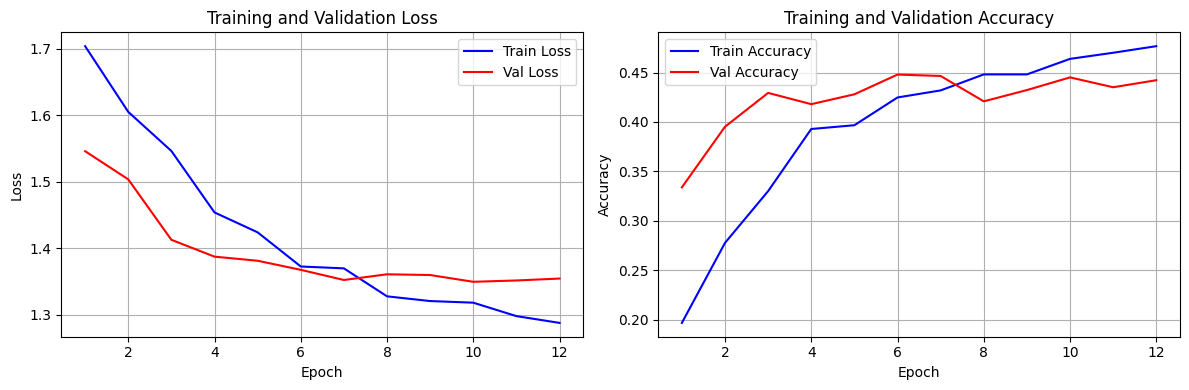


Training Final_Balanced
Architecture: PRODUCTION RECOMMENDED: Mean pooling + balanced architecture


Epoch 1/15
Train Loss: 1.7057, Train Accuracy: 0.1843
Val Loss: 1.5577, Val Acc: 0.3096, Val Weighted-F1: 0.2828
✓ New best (val_weighted_f1 = 0.2828)

Epoch 2/15
Train Loss: 1.5716, Train Accuracy: 0.3071
Val Loss: 1.4980, Val Acc: 0.4137, Val Weighted-F1: 0.3311
✓ New best (val_weighted_f1 = 0.3311)

Epoch 3/15
Train Loss: 1.4572, Train Accuracy: 0.4057
Val Loss: 1.4085, Val Acc: 0.4251, Val Weighted-F1: 0.3860
✓ New best (val_weighted_f1 = 0.3860)

Epoch 4/15
Train Loss: 1.4051, Train Accuracy: 0.4114
Val Loss: 1.3780, Val Acc: 0.4194, Val Weighted-F1: 0.4136
✓ New best (val_weighted_f1 = 0.4136)

Epoch 5/15
Train Loss: 1.3516, Train Accuracy: 0.4514
Val Loss: 1.3871, Val Acc: 0.4037, Val Weighted-F1: 0.3893

Epoch 6/15
Train Loss: 1.3273, Train Accuracy: 0.4824
Val Loss: 1.3711, Val Acc: 0.4223, Val Weighted-F1: 0.3990

Epoch 7/15
Train Loss: 1.2852, Train Accuracy: 0.4890
Val Loss

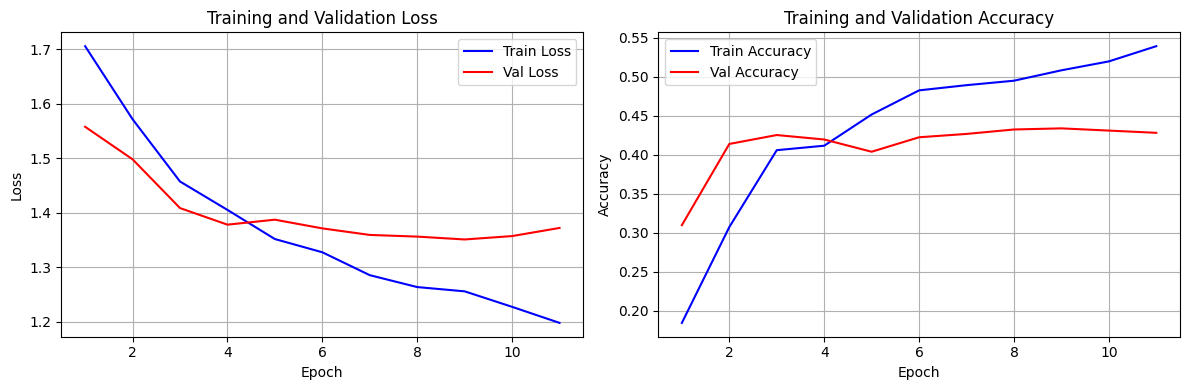

In [20]:
# Train each model (simplified training loop for notebook)
for config in model_configs:
    print(f"\n{'='*80}")
    print(f"Training {config['name']}")
    print(f"Architecture: {config['description']}")
    print(f"{'='*80}\n")
    
    # Load fresh base transformer
    base_transformer = AutoModel.from_pretrained(model_name)
    model = config['class'](base_transformer, num_classes=num_labels)
    model.to(device)
    
    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    effective_steps_per_epoch = math.ceil(len(train_loader) / max(1, grad_acc_steps))
    total_steps = effective_steps_per_epoch * epochs
    warmup_steps = int(0.15 * total_steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    
    # Training loop
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_macro_f1': [], 'val_weighted_f1': []}
    best_metric_val = -float('inf')
    no_improve_epochs = 0
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device, criterion, grad_acc_steps)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        
        if val_loader is not None:
            val_loss, val_acc, val_preds, val_trues = evaluate(model, val_loader, device, criterion)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            val_macro_f1 = f1_score(val_trues, val_preds, average='macro')
            val_weighted_f1 = f1_score(val_trues, val_preds, average='weighted')
            history['val_macro_f1'].append(val_macro_f1)
            history['val_weighted_f1'].append(val_weighted_f1)
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Weighted-F1: {val_weighted_f1:.4f}")
            
            # Early stopping
            current = val_weighted_f1
            if current > best_metric_val + 1e-4:
                best_metric_val = current
                no_improve_epochs = 0
                print(f"✓ New best (val_weighted_f1 = {current:.4f})")
            else:
                no_improve_epochs += 1
                if no_improve_epochs >= early_stopping_patience:
                    print(f"Early stopping triggered")
                    break
    
    # Plot training history
    history_plot_path = os.path.join(reports_dir, f'04-{config["name"].lower().replace(" ", "_")}_history.png')
    plot_training_history(history, history_plot_path)
    
    # Store results
    all_results[config['name']] = {
        'name': config['name'],
        'train_acc': history['train_acc'][-1],
        'val_acc': history['val_acc'][-1] if history['val_acc'] else 0.0,
        'val_macro_f1': history['val_macro_f1'][-1] if history['val_macro_f1'] else 0.0,
        'val_weighted_f1': best_metric_val,
        'epochs_trained': len(history['train_acc'])
    }
    
    # Clean up GPU memory
    del base_transformer, model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

## Results Comparison

In [21]:
# Summary
print(f"\n{'='*80}")
print(f"FINAL RESULTS SUMMARY")
print(f"{'='*80}\n")

for name, result in all_results.items():
    print(f"{name}:")
    print(f"  Train Acc: {result['train_acc']:.4f} | Val Acc: {result['val_acc']:.4f}")
    print(f"  Val Weighted F1: {result['val_weighted_f1']:.4f} | Val Macro F1: {result['val_macro_f1']:.4f}")
    print(f"  Epochs Trained: {result['epochs_trained']}")
    print(f"  Gap (Train-Val): {result['train_acc'] - result['val_acc']:.4f}")
    print()

# Save summary JSON
summary_path = os.path.join(reports_dir, '04-expansion_summary.json')
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(all_results, f, ensure_ascii=False, indent=2)
print(f"Summary saved to {summary_path}")


FINAL RESULTS SUMMARY

Step1_Baseline:
  Train Acc: 0.6333 | Val Acc: 0.4280
  Val Weighted F1: 0.4385 | Val Macro F1: 0.3789
  Epochs Trained: 9
  Gap (Train-Val): 0.2054

Step2_Extended:
  Train Acc: 0.4557 | Val Acc: 0.4322
  Val Weighted F1: 0.4328 | Val Macro F1: 0.3514
  Epochs Trained: 15
  Gap (Train-Val): 0.0235

Step3_Advanced:
  Train Acc: 0.4767 | Val Acc: 0.4422
  Val Weighted F1: 0.4337 | Val Macro F1: 0.3742
  Epochs Trained: 12
  Gap (Train-Val): 0.0344

Final_Balanced:
  Train Acc: 0.5390 | Val Acc: 0.4280
  Val Weighted F1: 0.4302 | Val Macro F1: 0.3761
  Epochs Trained: 11
  Gap (Train-Val): 0.1111

Summary saved to /app/output/reports/04-expansion_summary.json


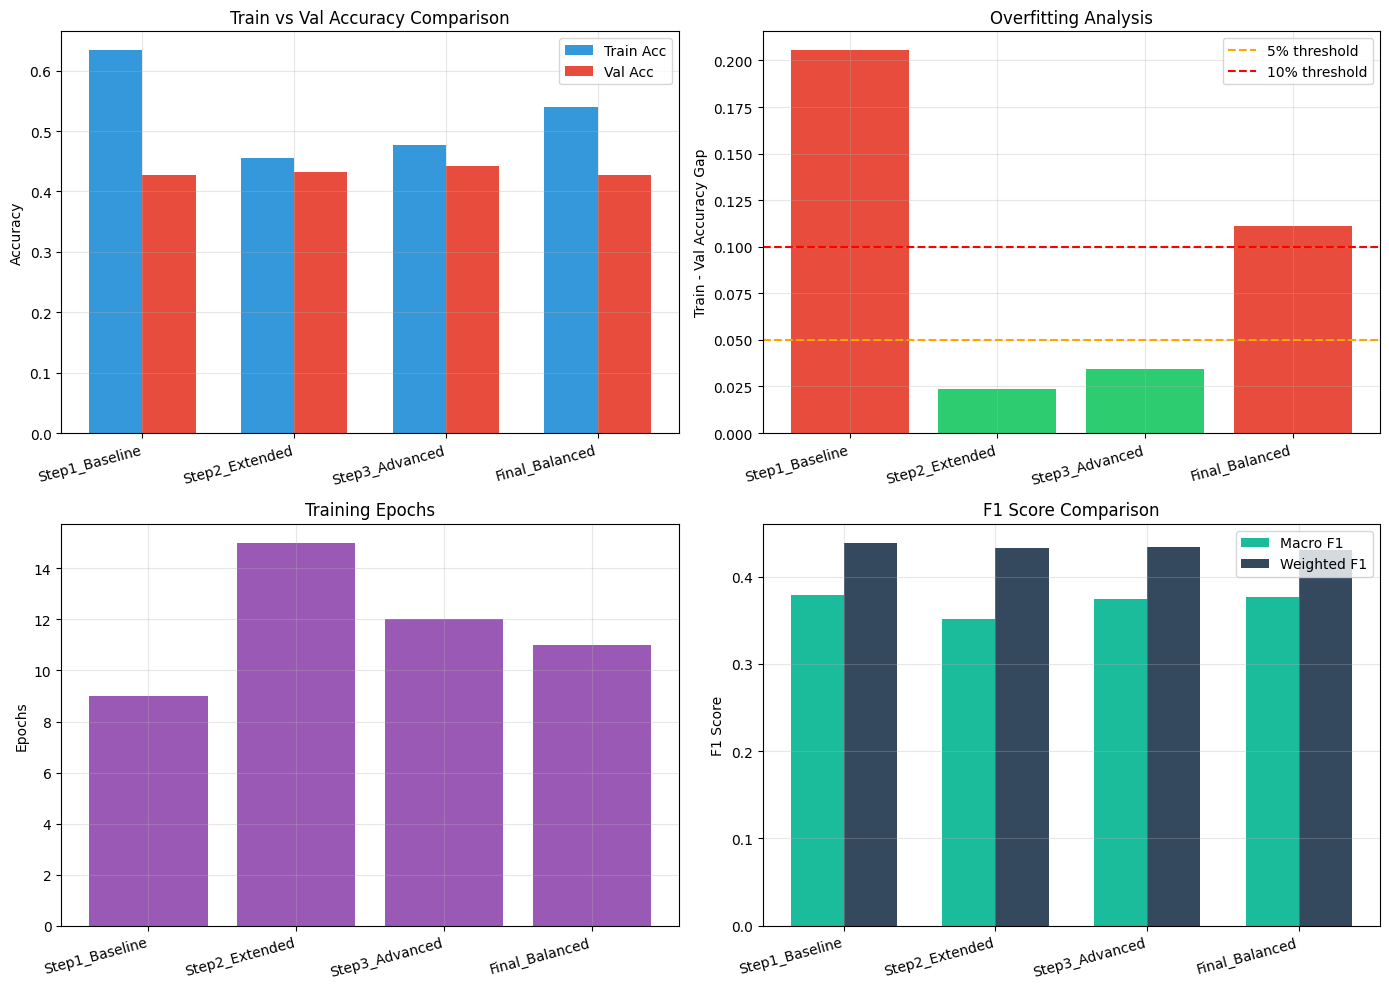

Model comparison plot saved to /app/output/reports/04-model_expansion_comparison.png


In [22]:
# Generate comparison plot
comparison_plot_path = os.path.join(reports_dir, '04-model_expansion_comparison.png')
plot_model_comparison(all_results, comparison_plot_path)

In [23]:
# Identify best model
best_name, best_result = max(all_results.items(), key=lambda kv: kv[1]['val_weighted_f1'])
print(f"\n{'='*80}")
print(f"BEST MODEL: {best_name}")
print(f"Val Weighted F1: {best_result['val_weighted_f1']:.4f}")
print(f"{'='*80}")


BEST MODEL: Step1_Baseline
Val Weighted F1: 0.4385
